In [ ]:
!pip install -q albumentations

In [ ]:
from __future__ import annotations

In [ ]:
import albumentations as A

In [ ]:
from pathlib import Path

from typing import NamedTuple
from typing import Optional

from PIL import Image

import gdown
import numpy as np
import matplotlib.pyplot as plt

import cv2
import albumentations as A

In [ ]:
# download the image we will use as an example

def download_from_gdrive(
    *,
    url: str,
    file_name: str,
    to_dir: Path,
    force: bool = False,
) -> Path:
    file_path = to_dir.joinpath(file_name)

    if force and file_path.exists():
        file_path.unlink()

    if not file_path.exists():
        gdown.download(
            url,
            output=str(file_path),
            quiet=False,
            fuzzy=True,
        )

    return file_path

download_from_gdrive(
    url="https://drive.google.com/file/d/1_Q98Y-uTl4rS_YxuXDLbRP5MQr3lZmhp/view?usp=sharing",
    file_name="000000000025.jpg",
    to_dir=Path("/content"))

Downloading...
From: https://drive.google.com/uc?id=1_Q98Y-uTl4rS_YxuXDLbRP5MQr3lZmhp
To: /content/000000000025.jpg
100%|██████████| 89.7k/89.7k [00:00<00:00, 5.42MB/s]


PosixPath('/content/000000000025.jpg')

In [ ]:
class BoundingBox(NamedTuple):
    x_min: float
    y_min: float
    x_max: float
    y_max: float

    @staticmethod
    def from_list(box: list[float]) -> BoundingBox:
      return BoundingBox(x_min=box[0], y_min=box[1], x_max=box[2], y_max=box[3])

    @staticmethod
    def from_list_of_boxes(boxes: list[list[float]]) -> list[BoundingBox]:
      bboxes:list[BoundingBox] = []
      for b in boxes:
        bboxes.append(BoundingBox.from_list(b))

      return bboxes

In [ ]:
# Helps to display image
# and the bounding boxes on the various objects

def bbox_to_matplotlib_rect(bbox: BoundingBox, color: str):
    """Convert bounding box to matplotlib format."""
    return plt.Rectangle(
        xy=(bbox.x_min, bbox.y_min),
        width=bbox.x_max - bbox.x_min,
        height=bbox.y_max - bbox.y_min,
        fill=False,
        edgecolor=color,
        linewidth=3,
    )

def add_box_to_figure(figure, bbox: BoundingBox, color: str):
    p = figure.axes.add_patch(bbox_to_matplotlib_rect(bbox, color))
    return p

def make_image_figure_with_bboxes(
    image: np.ndarray,
    bounding_boxes: list[BoundingBox]
):

    plt.figure(figsize=(16, 10))

    figure = plt.imshow(image)

    colors = ["blue"] * len(bounding_boxes)

    # add these anchor boxes we have
    for idx, c in enumerate(colors):
        patch = add_box_to_figure(figure, bounding_boxes[idx], c)


    plt.xlim((0, image.shape[1]))
    plt.ylim((image.shape[0], 0))

    plt.show()


In [ ]:
image_path = "/content/000000000025.jpg"

np_image = np.array(Image.open(image_path).convert("RGB"))

boxes = [
    BoundingBox(x_min=385, y_min=60, x_max=600, y_max=357),
    BoundingBox(x_min=53, y_min=356, x_max=185, y_max=411)
]

image_height, image_width, _ = np_image.shape

image_height, image_width

(426, 640)

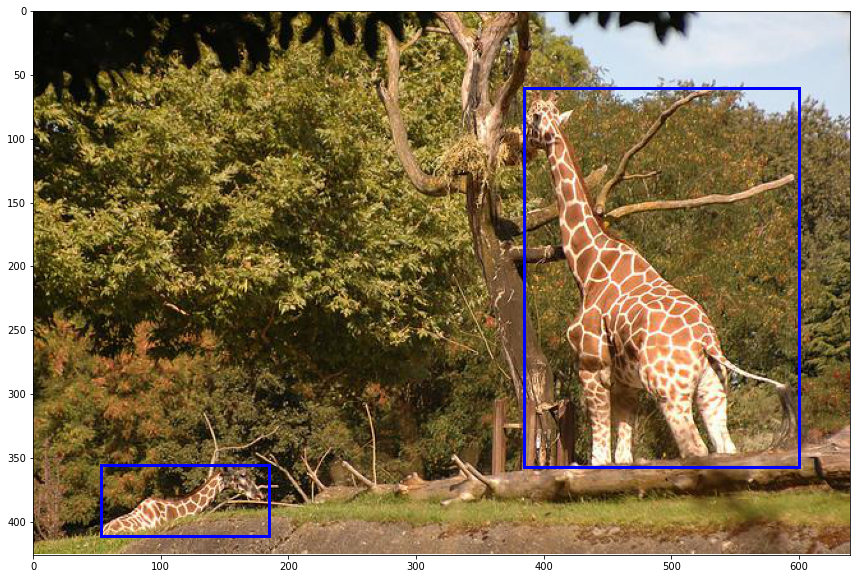

In [ ]:
make_image_figure_with_bboxes(np_image, boxes)

## Resize Transform

In [ ]:
TARGET_HEIGHT = 416
TARGET_WIDTH = 416

In [ ]:
resize_transform = A.Compose([
      A.Resize(height=TARGET_HEIGHT, width=TARGET_WIDTH),
    ], bbox_params = A.BboxParams(
        format="pascal_voc",
        label_fields=["class_labels"],
    ))

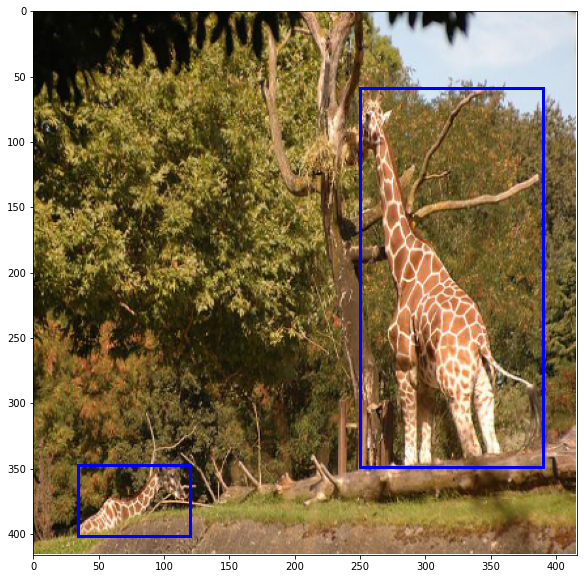

In [ ]:
resized_transform_result = resize_transform(
    image=np_image, bboxes=boxes, class_labels=[3, 3])

resized_image = resized_transform_result["image"]
resized_boxes = resized_transform_result["bboxes"]

make_image_figure_with_bboxes(
    resized_image,
    BoundingBox.from_list_of_boxes(resized_boxes)
)

## Letter Box

In [ ]:
letter_box_transform = A.Compose([
    A.LongestMaxSize(max_size=TARGET_HEIGHT, interpolation=cv2.INTER_LINEAR),
    A.PadIfNeeded(
        min_height=TARGET_HEIGHT,
        min_width=TARGET_HEIGHT,
        border_mode=cv2.BORDER_CONSTANT,
        value=(114, 114, 114),
    ),
  ],bbox_params = A.BboxParams(
        format="pascal_voc",
        label_fields=["class_labels"],
    ))

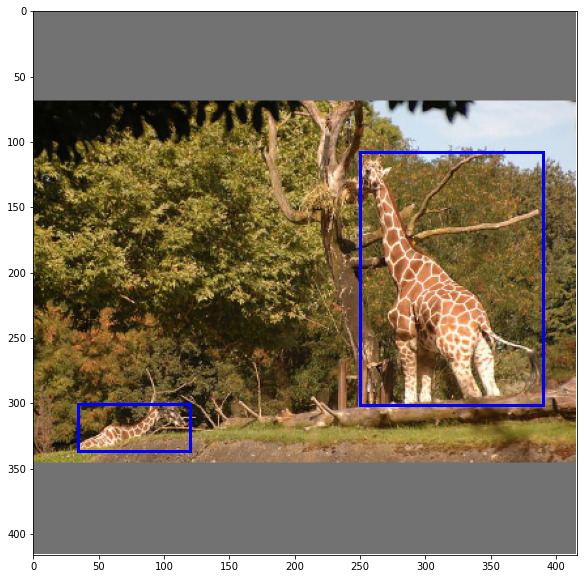

In [ ]:
letter_box_result = letter_box_transform(image=np_image, bboxes=boxes, class_labels=[3, 3])

letter_box_image = letter_box_result["image"]
letter_box_bboxes = letter_box_result["bboxes"]

make_image_figure_with_bboxes(
    letter_box_image,
    BoundingBox.from_list_of_boxes(letter_box_bboxes))

## Horizontal Flip

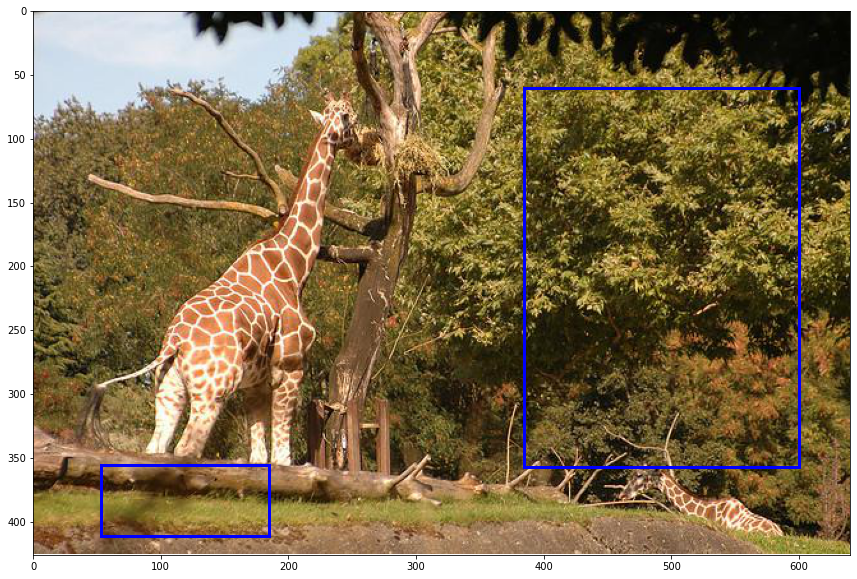

In [ ]:
horizontal_flip_transform = A.Compose([
    A.HorizontalFlip(p=1.)
])

horizontal_flipped_image = horizontal_flip_transform(image=np_image)["image"]

make_image_figure_with_bboxes(horizontal_flipped_image, boxes)

In [ ]:
transform_pipeline = A.Compose([
    A.Affine(
        scale=(0.5, 1.5),
        translate_percent=(0.1, 0.1),
        rotate=0.0,
        shear=0.0,
        cval=(114, 114, 114),
        p=1.0,
    ),
    A.Blur(p=0.01),
    A.MedianBlur(p=0.01),
    A.ToGray(p=0.01),
    A.CLAHE(p=0.01),
    A.ColorJitter(
        contrast=0.0,
        saturation=0.7,
        hue=0.015,
        brightness=0.4,
    ),
    A.HorizontalFlip(p=0.5),
    # letter box
    A.LongestMaxSize(max_size=TARGET_HEIGHT, interpolation=cv2.INTER_LINEAR),
    A.PadIfNeeded(
      min_height=TARGET_HEIGHT,
      min_width=TARGET_HEIGHT,
      border_mode=cv2.BORDER_CONSTANT,
      value=(114, 114, 114),
    ),
  ],bbox_params = A.BboxParams(
        format="pascal_voc",
        label_fields=["class_labels"],
    ))

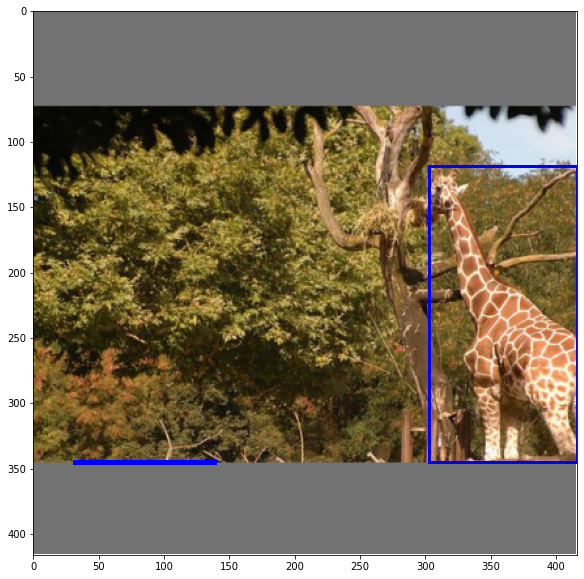

In [ ]:
transform_pipeline_result = transform_pipeline(image=np_image, bboxes=boxes, class_labels=[3, 3])

transformed_image = transform_pipeline_result["image"]
transformed_bboxes = transform_pipeline_result["bboxes"]

make_image_figure_with_bboxes(
    transformed_image,
    BoundingBox.from_list_of_boxes(transformed_bboxes))



## Tensor Transform

In [ ]:
from albumentations.pytorch import ToTensorV2

In [ ]:
basic_transform = A.Compose([
    A.LongestMaxSize(max_size=TARGET_HEIGHT, interpolation=cv2.INTER_LINEAR),
    A.PadIfNeeded(
        min_height=TARGET_HEIGHT,
        min_width=TARGET_HEIGHT,
        border_mode=cv2.BORDER_CONSTANT,
        value=(114, 114, 114),
    ),
    A.ToFloat(max_value=255.0),
    ToTensorV2(),
  ],bbox_params = A.BboxParams(
        format="pascal_voc",
        label_fields=["class_labels"],
    )
)


In [ ]:
basic_transform_result = basic_transform(image=np_image, bboxes=boxes, class_labels=[3, 3])

basic_transformed_image = basic_transform_result["image"]
basic_transformed_bboxes = basic_transform_result["bboxes"]
basic_transformed_labels = basic_transform_result["class_labels"]

basic_transformed_image.shape


torch.Size([3, 416, 416])